# Variational autoencoders (VAEs)

Variational autoencoders are a kind of generative model that is especially appropriate for the task of image editing via concept vectors. They are a modern take on autoencoders -- a type of network that aims to "encode" an input to a low-dimensional latent space then "decode" it back -- that mixes ideas from deep learning with Bayesian inference.

A VAE, instead of compressing its input image into a fixed "code" in the latent space like classical autoencoders, **turns the image into the parameters of a statistical distribution: a mean and a variance**. Essentially, this means that we are assuming that the input image has been generated by a statistical process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere, i.e. every point sampled in the latent will be decoded to a valid output.

<img src="./resources/vae.png"/>

In technical terms, a variational autoencoder works according to these 3 steps:
1. An encoder module turns the input samples `input_img` into two parameters in a latent space of representations, which we will note `z_mean` and `z_log_variance`.
2. Randomly sample a point `z` from the latent normal distribution that is assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values.
3. A decoder module will map this point in the latent space back to the original input image. Because `epsilon` is random, the process ensures that every point that is close to the latent location where we encoded `input_img` (z-mean) can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: first, a reconstruction loss that forces the decoded samples to match the initial inputs, and a regularization loss, which helps in learning well-formed latent spaces and reducing overfitting to the training data.

## Implement a VAE in Keras

Schematically, implementing a VAE in Keras requires the following steps:

```python
# Encode the input into a mean and variance parameter
z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
reconstructed_img = decoder(z)

# Instantiate a model
model = Model(input_img, reconstructed_img)

# Then train the model using 2 losses:
# a reconstruction loss and a regularization loss
```

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model


In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
train_size = 60000
batch_size = 32
test_size = 10000

train_ds = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_ds = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

### Build the network

#### Encoder

The encoder network we will use is a very simple convnet which maps the input image x to two vectors, `zmean` and `logvar`. The function implementing it is `encode()`.

#### Decoder
The decoder reshapes the vector `z` to the dimensions of an image, then uses a few convolution layers to obtain a final image output that has the same dimensions as the original `input_img`. The function implementing it is `decode()`.

Here's the implementation of the entire VAE:

In [4]:
class VAE(tf.keras.Model):
    """Variational autoencoder."""

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function             # wrapper function means all function inside this are wrapped
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

To generate a sample for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In the implementation above, we approximate using the decoder parameters and another parameter as follows:

```z = mean + logvar * epsilon```

The latent variable `z` is now generated by a function of `mean`, `logvar`  and `epsilon`, which would enable the model to backpropagate gradients in the encoder through `mean` and `logvar` respectively, while maintaining stochasticity through `epsilon`.

### Instantiate the model and loss function

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood.
In practice, we optimize the single sample Monte Carlo estimate of this expectation:

log p(x|z) + log p(z) - log q (z|x)

In [5]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
optimizer = tf.keras.optimizers.Adam(1e-4)

model = VAE(latent_dim)

In [6]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Train the model

In [7]:
import time

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_ds:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_ds:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))

Epoch: 1, Test set ELBO: -181.34243774414062, time elapse for current epoch: 98.36983036994934
Epoch: 2, Test set ELBO: -171.73558044433594, time elapse for current epoch: 79.4062397480011
Epoch: 3, Test set ELBO: -167.5951690673828, time elapse for current epoch: 77.36923456192017
Epoch: 4, Test set ELBO: -164.09420776367188, time elapse for current epoch: 76.35826063156128
Epoch: 5, Test set ELBO: -161.56689453125, time elapse for current epoch: 81.37389373779297
Epoch: 6, Test set ELBO: -160.1383514404297, time elapse for current epoch: 79.43142914772034
Epoch: 7, Test set ELBO: -158.59213256835938, time elapse for current epoch: 78.88887333869934
Epoch: 8, Test set ELBO: -158.37503051757812, time elapse for current epoch: 79.76004767417908
Epoch: 9, Test set ELBO: -157.0504150390625, time elapse for current epoch: 79.09165096282959
Epoch: 10, Test set ELBO: -156.35035705566406, time elapse for current epoch: 77.51758933067322


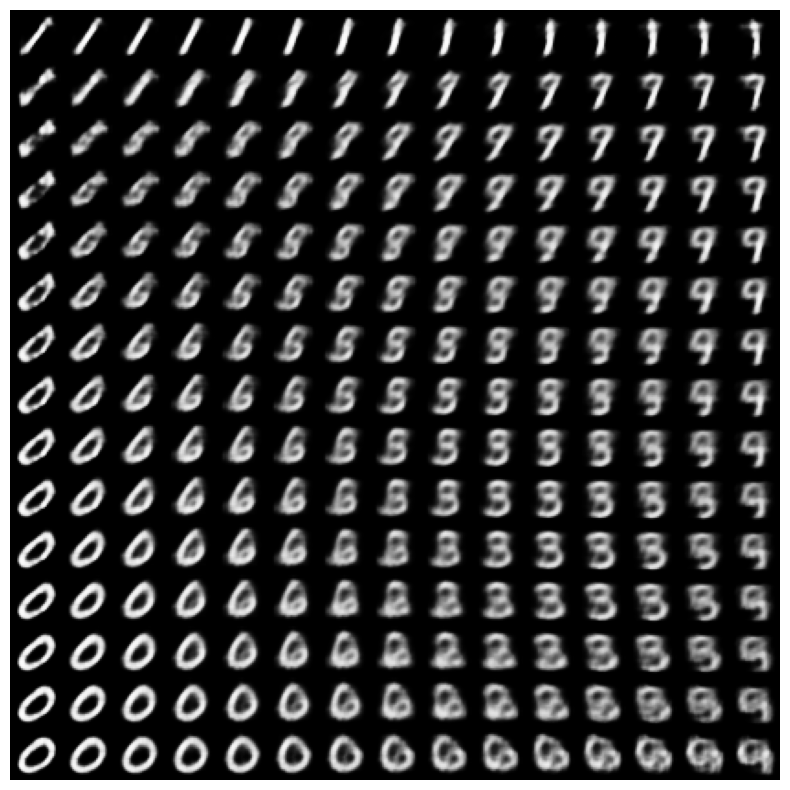

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm

digit_size = 28
n = 15 #figure with 15 x 15 digits
figure = np.zeros((digit_size * n, digit_size * n))

# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = model.sample(z_sample)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('Off')
plt.show()

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "three-ness", "one-ness", etc.